# Homework: Not So Basic Artificial Neural Networks

Your task is to implement a simple framework for convolutional neural networks training. While convolutional neural networks is a subject of lecture 3, we expect that there are a lot of students who are familiar with the topic.

In order to successfully pass this homework, you will have to:

- Implement all the blocks in `homework_modules.ipynb` (esp `Conv2d` and `MaxPool2d` layers). Good implementation should pass all the tests in `homework_test_modules.ipynb`.
- Settle with a bit of math in `homework_differentiation.ipynb`
- Train a CNN that has at least one `Conv2d` layer, `MaxPool2d` layer and `BatchNormalization` layer and achieves at least 97% accuracy on MNIST test set.

Feel free to use `homework_main-basic.ipynb` for debugging or as source of code snippets. 

Note, that this homework requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook with cnn trained
- `homework_modules.ipynb`
- `homework_differentiation.ipynb`

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import sys

In [3]:
# (re-)load layers
%run ../modules/numpy_modules.ipynb

In [4]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]
        
class OneHotEncoder:
    def __init__(self, n=10):
        self.transform_mapping = np.zeros((n,n))
        for i in range(n):
            self.transform_mapping[i][i] = 1.0
        #np.identity(n, dtype=None)[source]
    def transform(self, y):
        return self.transform_mapping[int(y)]

In [5]:
# Data preprossing
sys.path.insert(0, '../data/MNIST/')
import mnist_loader
X_train, y_train, X_val, y_val, X_test, y_test = mnist_loader.load_dataset()  # load dataset

#Create more data -- rotate all images 90 degrees left and right, translate some of them
X_train_rot90_left = np.rot90(X_train, k=1, axes=(1,2))#.reshape(X_train.shape[0], -1)
X_train_rot90_right = np.rot90(X_train, k=3, axes=(1,2))#.reshape(X_train.shape[0], -1)
# X_train_translated = np.flip(X_train, 2)#.reshape(X_train.shape[0], -1) # Flip image along vertical axes 

X_augmented = np.vstack((X_train, X_train_rot90_left, X_train_rot90_right))
y_augmented = np.hstack(([y_train, ], [y_train, ], [y_train, ])).T.reshape(-1)

In [6]:
# Convert to OHE 
encoder = OneHotEncoder()
y_augmented_ohe = np.array(list(map(lambda x: encoder.transform(x), y_augmented)))

In [8]:
# Your turn - train and evaluate conv neural network
    
# Define the network using architecture from this video https://www.youtube.com/watch?v=pQ9Y9ZagZBk
# batch_size x n_channels x H x W
net = Sequential() # batch_size x 1 x 28 x 28
# here conv2d pad data and preserver's length
net.add(Conv2d(1, 32, 5)) # batch_size x 32 x 28 x 28
net.add(MaxPool2d(2)) # batch_size x 32 x 14 x 14
net.add(Conv2d(32, 64, 5)) # batch_size x 64 x 14 x 14
net.add(MaxPool2d(2)) # batch_size x 64 x 7 x 7
net.add(Flatten())
# net.add(Linear(784, 50))
net.add(Linear(7*7*64, 50))
net.add(LeakyReLU(slope=0.01))
net.add(BatchNormalization(alpha=0.99))
net.add(ChannelwiseScaling(50))
net.add(Linear(50, 10))
net.add(LogSoftMax())

# Set network to training mode (important for BN layer)
net.train()

# Optimizer params
# optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9} # for SGD_momentum
optimizer_config = {'learning_rate': 1e-3, 'beta1': 0.9, 'beta2':0.999, 'epsilon':1e-8} # for ADAM
optimizer_state = {}

# Looping params
n_epoch = 30
batch_size = 10

criterion = ClassNLLCriterion()

In [9]:
y_augmented_ohe.shape

(150000, 10)

In [10]:
X_augmented = X_augmented[:50]
y_augmented = y_augmented[:50]

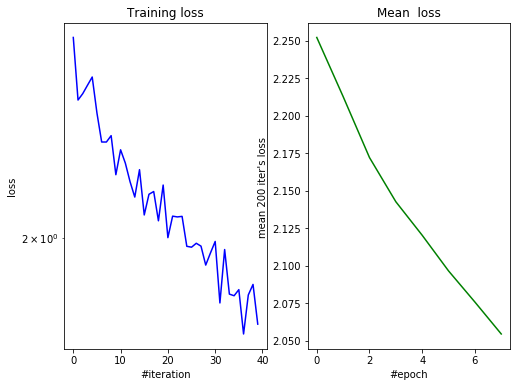

Current loss: 1.874829


KeyboardInterrupt: 

In [11]:
#Magic happens here
loss_history = []
loss_history_epoch = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X_augmented[:, None, :, :], y_augmented_ohe), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
          
        adam_optimizer(net.getParameters(),
             net.getGradParameters(),
             optimizer_config,
             optimizer_state)
        
        loss_history.append(loss)
        
    
    loss_history_epoch.append(np.mean(loss_history[-len(X_augmented) // batch_size:]))
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.subplot(1, 2, 1)
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.yscale('log')

    plt.subplot(1, 2, 2)
    plt.title("Mean  loss")
    plt.xlabel("#epoch")
    plt.ylabel("mean 200 iter's loss ")
    plt.plot(loss_history_epoch, 'g')

    plt.show()
    
    print('Current loss: %f' % loss)  
    

In [15]:
# Predict test and compute accuracy
net.evaluate()
from sklearn.metrics import accuracy_score
y_pred = net.forward(X_test) 
# Convert predictions from OHE to class labels
y_pred = [pred.index(max(pred)) for pred in y_pred]

# acc = accuracy_score(y_test, y_pred)

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (4,2) and requested shape (3,2)

Print here your accuracy on test set. It should be >97%. Don't forget to switch the network in 'evaluate' mode